In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Setup base directory for loading files

In [2]:
username= "ncaplar"
basedir = f"/astro/users/{username}/data/"

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.adapt(minimum=1, maximum=40) 

ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46261 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46261/status,
Dashboard: http://127.0.0.1:46261/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38082,Workers: 8
Dashboard: http://127.0.0.1:46261/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:45289,Total threads: 8
Dashboard: http://127.0.0.1:44740/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:42470,


In [4]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=True)

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1736: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1758: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1286: UserWarning: Divisions for object are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1286: UserWarning: Divisions for source are not set, certain downstream dask operations may fail a

In [5]:
"""
0. Negative log-likelihood of the Gaussian Process model
1. log_drw_scale = theta[0]
2. log_drw_amp = theta[1]
3. log_per_scale = theta[2]
4. log_per_amp = theta[3]
"""

res_tsp_run_0 = pd.read_parquet(f"{basedir}/res_tsp_run_g_0.parquet", engine='pyarrow')
res_tsp_run_0_drw = pd.read_parquet(f"{basedir}/res_tsp_run_g_0_drw.parquet", engine='pyarrow')
# numpy version of the results
res_tsp_run_0_np = np.vstack(res_tsp_run_0.values)
# res_tsp_run_0_drw = pd.read_parquet('/astro/users/ncaplar/data/res_tsp_run_0_drw', engine='pyarrow')
# res_tsp_run_0_drw_np = np.vstack(res_tsp_run_0_drw.data.values)

2024-01-02 10:12:24,196 - distributed.core - INFO - Connection to tcp://127.0.0.1:38082 has been closed.
2024-01-02 10:12:26,639 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:38147'.
2024-01-02 10:12:26,641 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:38147'. Shutting down.
2024-01-02 10:12:26,668 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43299'.
2024-01-02 10:12:26,669 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:43299'. Shutting down.
2024-01-02 10:12:29,522 - distributed.nanny - WARNING - Worker process still alive after 3.199998474121094 seconds, killing
2024-01-02 10:12:29,525 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-01-02 10:12:30,638 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:405

In [9]:
name_str = '024337.17-002340.2'

ts_computed = ens.source.compute().loc[name_str]
ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']

ens.source.compute().loc[name_str]

ens.query("band_ztf_source == 'g'", table = 'source')
ts = ens.source.compute().loc[name_str]
t = ts['mjd_ztf_source'].values
sort_array = np.argsort(t)
t = t[sort_array]
y = ts['mag_ztf_source'].values[sort_array]
yerr = ts['magerr_ztf_source'].values[sort_array]

t_r = ts_computed_r['mjd_ztf_source'].values
y_r = ts_computed_r['mag_ztf_source'].values
yerr_r = ts_computed_r['magerr_ztf_source'].values

In [10]:
x = np.linspace(np.min(t) - 100, np.max(t) + 100, 2000)


JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
theta = res_tsp_run_0.loc[name_str][2:6].values
theta_drw = res_tsp_run_0_drw.loc[name_str][2:4].values

gp = JaxPeriodDrwFit_instance.build_gp(theta, t, y, yerr)
gp_drw = JaxPeriodDrwFit_instance.build_gp_drw(theta_drw, t, y, yerr)

cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

cond_gp_drw = gp_drw.condition(y, x).gp
mu_drw, var_drw = cond_gp_drw.loc, cond_gp_drw.variance

mu_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.loc
var_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.variance

mu_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.loc
var_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.variance

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
# To optimize per one
#JaxPeriodDrwFit_instance.optimize_map(t, y, yerr, n_init = 10000)

In [11]:
res_tsp_run_0.loc[name_str]

min_neg_log_lh       -43.355501
neg_log_lh           -43.355501
log_drw_scale          3.150037
log_drw_amp           -0.787915
log_per_scale          2.996490
log_per_amp           -1.053942
init_log_drw_scale     4.330881
init_log_drw_amp       0.777756
init_log_per_scale     3.317509
init_log_per_amp      -2.111870
Name: 024337.17-002340.2, dtype: float64

In [12]:
res_tsp_run_0_drw.loc[name_str]

min_neg_log_lh       -57.230499
neg_log_lh           -57.230499
log_drw_scale         28.407915
log_drw_amp            7.630029
init_log_drw_scale     0.998369
init_log_drw_amp       1.090074
Name: 024337.17-002340.2, dtype: float64

In [ ]:
y_r

/tmp/ipykernel_65609/1723399926.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
/tmp/ipykernel_65609/1723399926.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')


(19.139538057316635, 19.824117164882882)

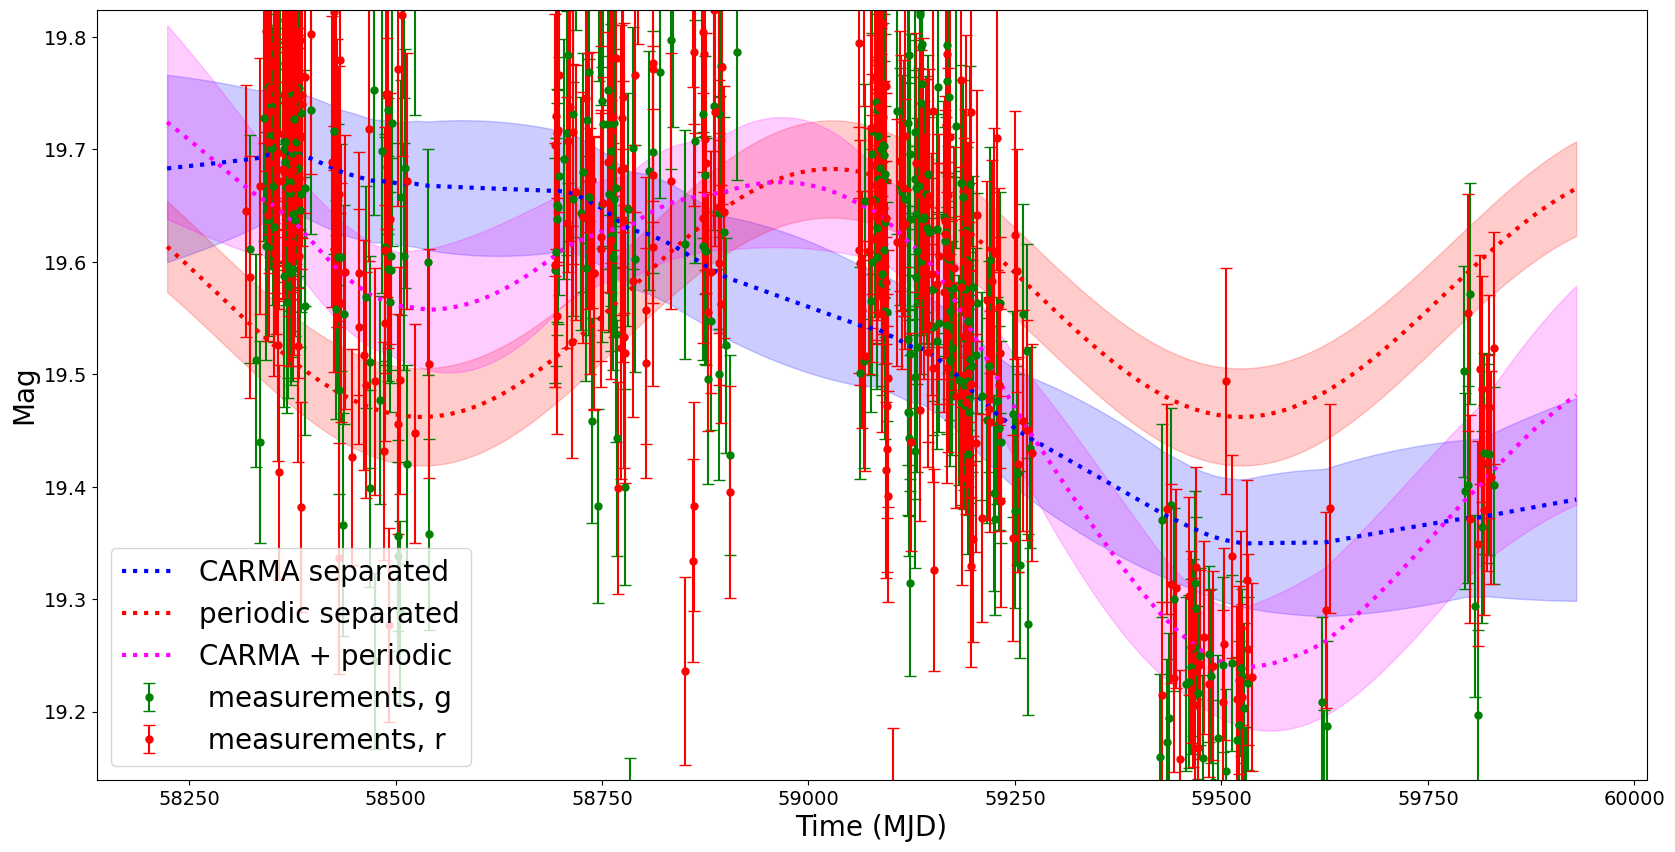

In [13]:
plt.figure(figsize=(20, 10))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')

plt.plot(x, mu_carma, color="blue", ls=':',lw=3, label = 'CARMA separated')
plt.plot(x, mu_periodic, color="red", ls=':', lw=3, label = 'periodic separated')

plt.fill_between(x, mu_carma + np.sqrt(var_carma),
                 mu_carma- np.sqrt(var_carma), color="blue", alpha=0.2)
plt.fill_between(x, mu_periodic + np.sqrt(var_periodic),
                 mu_periodic - np.sqrt(var_periodic), color="red", alpha=0.2)

plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="magenta", alpha=0.2)
plt.plot(x, mu, color="magenta", lw=3, ls=':', label = 'CARMA + periodic')

plt.xlabel("Time (MJD)", fontsize=20)
plt.ylabel("Mag", fontsize=20)
plt.legend(fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(np.min(mu)-0.1, np.max(mu)+0.1)

/tmp/ipykernel_65609/799996472.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
/tmp/ipykernel_65609/799996472.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')


Text(0.5, 1.0, 'Only DRW')

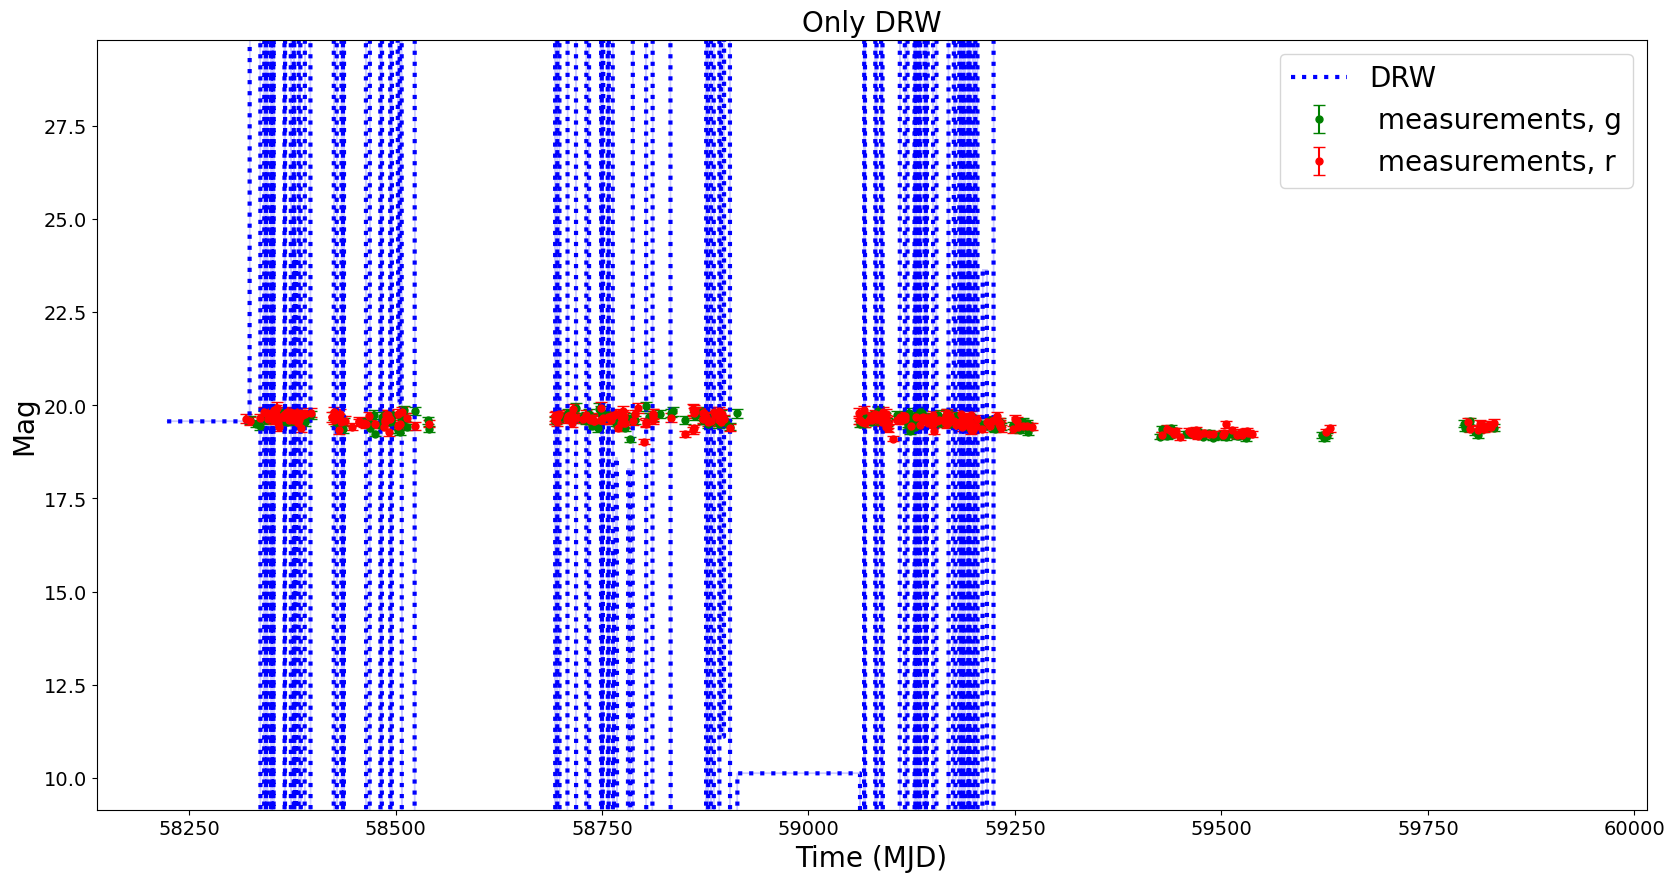

In [15]:
plt.figure(figsize=(20, 10))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')

plt.fill_between(x, mu_drw + np.sqrt(var_drw), mu_drw - np.sqrt(var_drw), color="blue", alpha=0.2)
plt.plot(x, mu_drw, color="blue", lw=3, ls=':', label = 'DRW')

plt.xlabel("Time (MJD)", fontsize=20)
plt.ylabel("Mag", fontsize=20)
plt.legend(fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(np.min(mu)-10.1, np.max(mu)+10.1)
plt.title('Only DRW',  fontsize=20)